In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

In [2]:
tools = pd.read_csv('tools_stocks.csv', parse_dates=['month_after'], index_col='month_after').iloc[:,1:].dropna()
tools.sort_index(inplace=True)
tools.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409000 entries, 1999-12-06 to 2018-10-30
Data columns (total 17 columns):
Open                     409000 non-null float64
High                     409000 non-null float64
Low                      409000 non-null float64
Close                    409000 non-null float64
Adj Close                409000 non-null float64
Volume                   409000 non-null int64
brand                    409000 non-null object
date_time                409000 non-null object
asin                     409000 non-null object
overall                  409000 non-null float64
Open_month_after         409000 non-null float64
High_month_after         409000 non-null float64
Low_month_after          409000 non-null float64
Close_month_after        409000 non-null float64
Adj Close_month_after    409000 non-null float64
Volume_month_after       409000 non-null int64
cat                      409000 non-null object
dtypes: float64(11), int64(2), object(4)
memory 

In [3]:
def monthly_change(df, col):
    ma = col+'_month_after'
    return df[ma].div(df[col])

In [4]:
tools['avg_price_daily'] = (tools['Open'] + tools['Close'])/2
tools['avg_price_daily_month_after'] = (tools['Open_month_after'] + tools['Close_month_after'])/2

In [5]:
tools.head()

,Open,High,Low,Close,Adj Close,Volume,brand,date_time,asin,overall,Open_month_after,High_month_after,Low_month_after,Close_month_after,Adj Close_month_after,Volume_month_after,cat,avg_price_daily,avg_price_daily_month_after
month_after,,,,,,,,,,,,,,,,,,,
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B00002X20X,5.0,31.125,32.375,31.125,32.125,19.352861,291600,Tools_and_Home_Improvement,27.46875,31.6250
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B0000302UJ,5.0,31.125,32.375,31.125,32.125,19.352861,291600,Tools_and_Home_Improvement,27.46875,31.6250
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B00002X20X,5.0,31.125,32.375,31.125,32.125,19.352861,291600,Tools_and_Home_Improvement,27.46875,31.6250
1999-12-06,27.2500,28.375,27.125,27.6875,16.563345,303900,Stanley Black & Decker,1999-11-08,B0000302UJ,5.0,31.125,32.375,31.125,32.125,19.352861,291600,Tools_and_Home_Improvement,27.46875,31.6250
1999-12-10,30.4375,31.375,30.250,31.1250,18.619738,270100,Stanley Black & Decker,1999-11-12,B00002X1XB,5.0,31.500,31.750,30.000,31.125,18.750437,144900,Tools_and_Home_Improvement,30.78125,31.3125


In [6]:
tools['avg_price_monthly_change'] = monthly_change(df=tools, col='avg_price_daily')

In [7]:
t_brands = tools['brand'].value_counts().index.values

In [ ]:
missing_dates / 

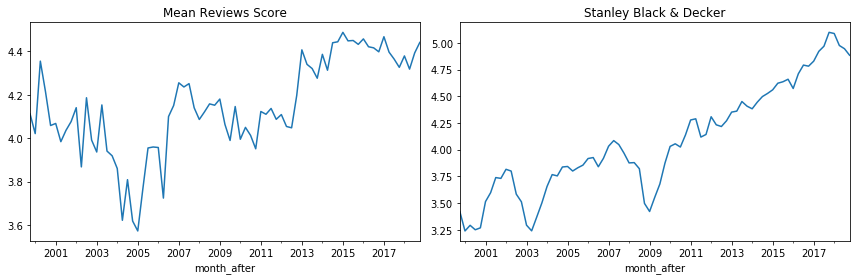

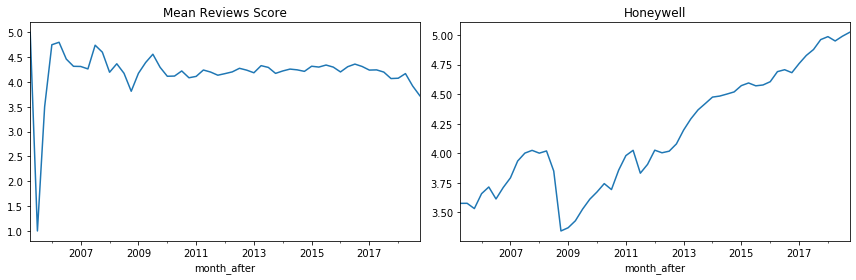

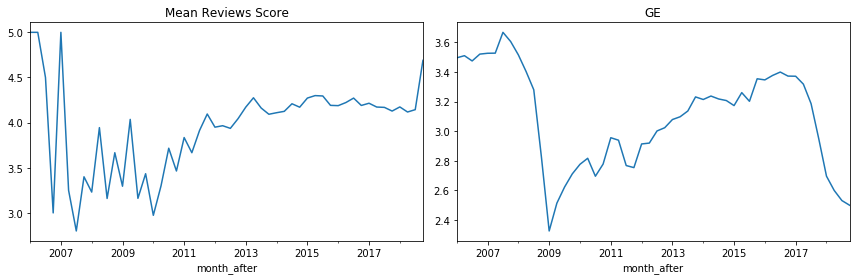

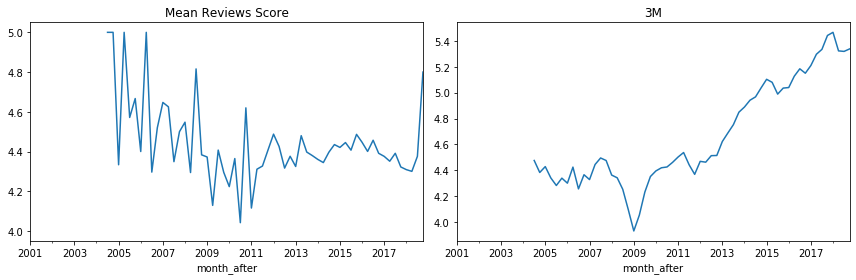

In [22]:
for b in t_brands:
    df = tools[tools['brand'] == b].resample('Q').mean()
    plt.subplots(1,2, figsize=[12,4])
    plt.subplot(1,2,1)
    df['overall'].plot(title='Mean Reviews Score')
    plt.subplot(1,2,2)
    df['avg_price_daily_month_after'].apply(np.log).plot()
    plt.tight_layout()
    plt.title(b)
    plt.show()

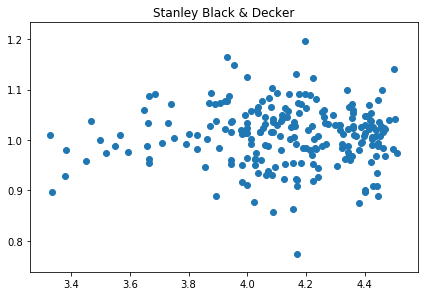

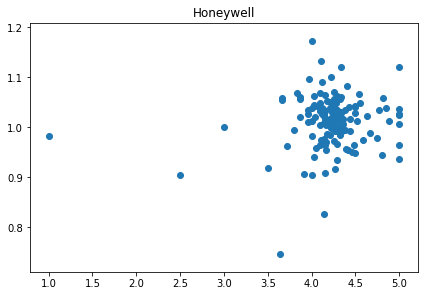

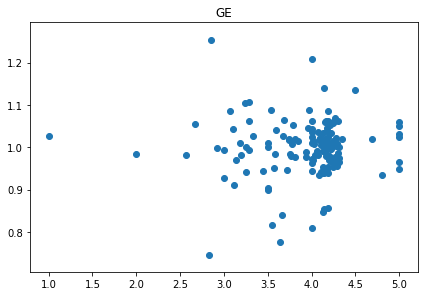

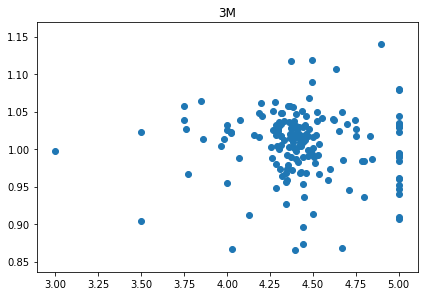

In [29]:
for b in t_brands:
    df = tools[tools['brand'] == b].resample('M').mean()
    plt.scatter(df['overall'], df['avg_price_monthly_change'])
    plt.tight_layout()
    plt.title(b)
    plt.show()

In [9]:
quarterly_averages = []
for b in t_brands:
    b_df = tools[tools['brand'] == b].groupby(['month_after']).mean()[['overall', 'avg_price_daily', 'avg_price_daily_month_after']].resample('QS', level='month_after').mean().asfreq('D', method='bfill')
    b_df['brand'] = b
    b_df.columns = ['mean_ratings_q', 'avg_price_q', 'avg_price_q_month_after', 'brand']
    quarterly_averages.append(b_df)
    
t_q = pd.concat(quarterly_averages, axis=0)

In [ ]:
tools['mean_quarterly_ratings_cat'] = tools

In [10]:
t_q.brand.value_counts()

Stanley Black & Decker    6941
3M                        6483
Honeywell                 4932
GE                        4657
Name: brand, dtype: int64

In [11]:
tools_dates = tools.index.unique().sort_values()

In [12]:
t_q.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23013 entries, 1999-10-01 to 2018-10-01
Data columns (total 4 columns):
mean_ratings_q             22103 non-null float64
avg_price_q                22103 non-null float64
avg_price_q_month_after    22103 non-null float64
brand                      23013 non-null object
dtypes: float64(3), object(1)
memory usage: 898.9+ KB


In [15]:
missing_dates = set(tools.index).difference(set(t_q.index))
missing_values = []
for b in t_brands:
    b_df = t_q[t_q['brand'] == b].reset_index()
    for date in missing_dates:
        v = b_df[b_df['month_after'] == b_df['month_after'].max()].reset_index()
        missing_values.append(v)

In [21]:
q_b_df = []
for b in t_brands:
    b_df = tools[tools['brand'] == b]
    print(b_df.join(t_q[t_q['brand']==b], on='month_after'))
    break;

ValueError: columns overlap but no suffix specified: Index(['brand'], dtype='object')

In [54]:
tools.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409000 entries, 1999-12-06 to 2018-10-30
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Open                         409000 non-null  float64
 1   High                         409000 non-null  float64
 2   Low                          409000 non-null  float64
 3   Close                        409000 non-null  float64
 4   Adj Close                    409000 non-null  float64
 5   Volume                       409000 non-null  int64  
 6   brand                        409000 non-null  object 
 7   date_time                    409000 non-null  object 
 8   asin                         409000 non-null  object 
 9   overall                      409000 non-null  float64
 10  Open_month_after             409000 non-null  float64
 11  High_month_after             409000 non-null  float64
 12  Low_month_after              409000 non-nu

In [71]:
#brand ratings q
brq = m.reset_index()['month_after'].apply(lambda x: t_q.loc[x, 'mean_ratings_q'])


In [72]:
mapq = m.reset_index()['month_after'].apply(lambda x: m_q.loc[x, 'avg_price_q'])
mapqma = m.reset_index()['month_after'].apply(lambda x: m_q.loc[x, 'avg_price_q_month_after'])

In [74]:
m['mean_ratings_q'] = mrq.values
m['avg_price_q'] = mapq.values
m['avg_price_q_month_after'] = mapqma.values

/home/jean-luc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jean-luc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jean-luc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [40]:
a = msf_apple[msf_apple['brand']=='Apple']
a_q = msf_apple_q_a[msf_apple_q_a['brand'] == 'Apple']

In [52]:
a_q = a_q.append(pd.DataFrame([[dt.datetime(2018, 10, 2), 4.137931034482759, 228.38500249999942, 228.26499950000078, 'Apple']],columns = ['month_after', 'mean_ratings_q', 'avg_price_q', 'avg_price_q_month_after', 'brand']).set_index('month_after'))

In [55]:
a_ma = a.reset_index()['month_after']
arq = a_ma.apply(lambda x: a_q.loc[x, 'mean_ratings_q'])
aapq = a_ma.apply(lambda x: a_q.loc[x, 'avg_price_q'])
aapqma = a_ma.apply(lambda x: a_q.loc[x, 'avg_price_q_month_after'])

In [59]:
a['mean_ratings_q'] = arq.values
a['avg_price_q'] = aapq.values
a['avg_price_q_month_after'] = aapqma.values

/home/jean-luc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jean-luc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jean-luc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [75]:
a_m = pd.concat([a, m], axis=0)

In [76]:
a_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4403604 entries, 2001-09-04 to 2018-10-02
Data columns (total 12 columns):
asin                           object
overall                        float64
brand                          object
cat                            object
Volume                         int64
Volume_month_after             float64
avg_price_daily                float64
avg_price_daily_month_after    float64
avg_price_monthly_change       float64
mean_ratings_q                 float64
avg_price_q                    float64
avg_price_q_month_after        float64
dtypes: float64(8), int64(1), object(3)
memory usage: 436.8+ MB


In [81]:
a_m.groupby(['month_after','brand']).mean()

,,overall,Volume,Volume_month_after,avg_price_daily,avg_price_daily_month_after,avg_price_monthly_change,mean_ratings_q,avg_price_q,avg_price_q_month_after
month_after,brand,,,,,,,,,
2001-09-04,Apple,5.000000,42137200,87053400.0,1.377857,1.312500,0.952566,4.519118,1.290200,1.411670
2001-09-18,Apple,3.000000,46425400,81775400.0,1.287857,1.185000,0.920133,4.519118,1.290200,1.411670
2001-09-20,Apple,5.000000,54269600,102793600.0,1.286072,1.141786,0.887809,4.519118,1.290200,1.411670
2001-09-21,Apple,2.000000,72583000,142629200.0,1.306072,1.090357,0.834837,4.519118,1.290200,1.411670
2001-09-26,Apple,5.000000,59992800,123449200.0,1.295357,1.105714,0.853598,4.519118,1.290200,1.411670
2001-09-28,Apple,4.666667,54226200,91277200.0,1.295714,1.115000,0.860529,4.519118,1.290200,1.411670
2001-10-02,Apple,4.750000,87053400,58970800.0,1.312500,1.088572,0.829388,4.512745,1.605882,1.665809
2001-10-05,Apple,3.500000,60457600,85671600.0,1.242143,1.126428,0.906843,4.512745,1.605882,1.665809
2001-10-16,Apple,3.500000,81775400,50737400.0,1.185000,1.289286,1.088005,4.512745,1.605882,1.665809


In [2]:
sony_microsoft_vg = pd.read_csv('sony_microsoft_stock_df.csv', parse_dates=['month_after'], index_col='month_after')
sony_microsoft_vg.head()

,Unnamed: 0,asin,brand,overall,date_time,Open,High,Low,Close,Adj Close,Volume,Open_month_after,High_month_after,Low_month_after,Close_month_after,Adj Close_month_after,Volume_month_after,cat
month_after,,,,,,,,,,,,,,,,,,
2011-08-09,0,9625990674,Microsoft,5.0,2011-07-12,26.549999,26.790001,26.34,26.540001,21.591339,47319300,24.709999,25.620001,24.030001,25.58,20.810333,126268900,Video Games
2011-08-09,1,9625990674,Microsoft,5.0,2011-07-12,26.549999,26.790001,26.34,26.540001,21.591339,47319300,24.709999,25.620001,24.030001,25.58,20.810333,126268900,Video Games
2011-08-09,2,9625990674,Microsoft,5.0,2011-07-12,26.549999,26.790001,26.34,26.540001,21.591339,47319300,24.709999,25.620001,24.030001,25.58,20.810333,126268900,Video Games
2011-08-09,3,9625990674,Microsoft,5.0,2011-07-12,26.549999,26.790001,26.34,26.540001,21.591339,47319300,24.709999,25.620001,24.030001,25.58,20.810333,126268900,Video Games
2011-08-09,4,B00005NZ1G,Microsoft,5.0,2011-07-12,26.549999,26.790001,26.34,26.540001,21.591339,47319300,24.709999,25.620001,24.030001,25.58,20.810333,126268900,Video Games


(array([135445.,      0.,  58163.,      0.,      0.,  93510.,      0.,
        190882.,      0., 850324.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

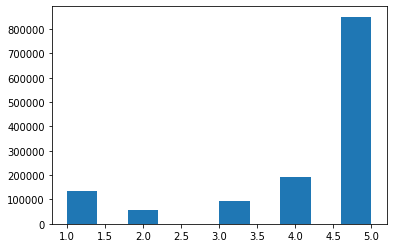

In [9]:
plt.hist(sony_microsoft_vg['overall'].values)

In [11]:
na_s = pd.read_csv('nike_adidas_sport_stocks.csv', parse_dates=['month_after'], index_col='month_after')

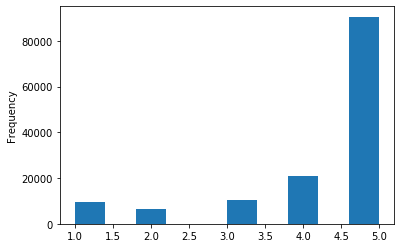

In [12]:
na_s['overall'].plot(kind='hist')

In [3]:
msf_apple = msf_apple.iloc[:,1:]

In [4]:
msf_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4404087 entries, 0 to 4404086
Data columns (total 18 columns):
asin                     object
overall                  float64
brand                    object
date_time                object
month_after              object
cat                      object
Open                     float64
High                     float64
Low                      float64
Close                    float64
Adj Close                float64
Volume                   int64
Open_month_after         float64
High_month_after         float64
Low_month_after          float64
Close_month_after        float64
Adj Close_month_after    float64
Volume_month_after       float64
dtypes: float64(12), int64(1), object(5)
memory usage: 604.8+ MB


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform()

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [ ]:
month_after_df[month_after_df['brand']=='Microsoft'].groupby(['month_after']).mean()['overall'].plot()

In [ ]:
month_after_df[month_after_df['brand']=='Microsoft'].groupby(['month_after']).mean()['Open_month_after'].plot()

In [ ]:
m_ma = month_after_df[month_after_df['brand'] =='Microsoft']
m_ma.groupby(['month_after']).size().plot()

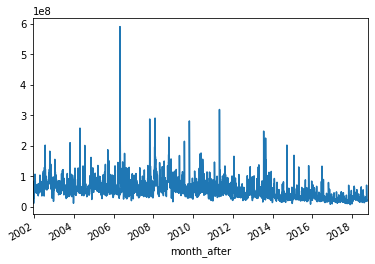

In [28]:
month_after_df[month_after_df['brand']=='Microsoft'].groupby(['month_after']).mean()['Volume_month_after'].plot()

In [32]:
month_after_df.groupby(['month_after', 'brand']).mean().reset_index().sort_values(by='month_after')

,month_after,brand,overall,Open_month_after,Low_month_after,High_month_after,Close_month_after,Volume_month_after
0,2001-09-04,Apple,5.000000,1.321429,1.298571,1.362857,1.303571,87053400.0
1,2001-09-18,Apple,3.000000,1.207143,1.155000,1.265714,1.162857,81775400.0
2,2001-09-20,Apple,5.000000,1.163571,1.107143,1.210714,1.120000,102793600.0
3,2001-09-21,Apple,2.000000,1.057143,1.048571,1.160714,1.123571,142629200.0
4,2001-09-26,Apple,5.000000,1.129286,1.066429,1.135000,1.082143,123449200.0
5,2001-09-28,Apple,4.666667,1.122143,1.099286,1.136429,1.107857,91277200.0
6,2001-10-02,Apple,4.750000,1.102143,1.062857,1.130714,1.075000,58970800.0
7,2001-10-05,Apple,3.500000,1.100000,1.070714,1.153571,1.152857,85671600.0
8,2001-10-16,Apple,3.500000,1.292143,1.269286,1.300000,1.286429,50737400.0
9,2001-10-18,Apple,2.500000,1.235000,1.235000,1.302143,1.285714,153143200.0


In [10]:
nike_adidas_sport = pd.read_csv('nike_adidas_sport_stocks.csv').iloc[:,1:]
nike_adidas_sport.head()

,asin,overall,brand,date_time,month_after,Open,High,Low,Close,Adj Close,Volume,Open_month_after,High_month_after,Low_month_after,Close_month_after,Adj Close_month_after,Volume_month_after,cat
0,B0002M584Y,5.0,Nike,2015-03-20,2015-04-17,51.314999,51.895,50.625,50.990002,47.91116,29779800,49.584999,49.685001,49.07,49.275002,46.299702,6049600,Sports and Outdoors
1,B0002M584Y,5.0,Nike,2015-03-20,2015-04-17,51.314999,51.895,50.625,50.990002,47.91116,29779800,49.584999,49.685001,49.07,49.275002,46.299702,6049600,Sports and Outdoors
2,B00448NFA6,4.0,Nike,2015-03-20,2015-04-17,51.314999,51.895,50.625,50.990002,47.91116,29779800,49.584999,49.685001,49.07,49.275002,46.299702,6049600,Sports and Outdoors
3,B0048L5M28,5.0,Nike,2015-03-20,2015-04-17,51.314999,51.895,50.625,50.990002,47.91116,29779800,49.584999,49.685001,49.07,49.275002,46.299702,6049600,Sports and Outdoors
4,B0059YIS7E,5.0,Nike,2015-03-20,2015-04-17,51.314999,51.895,50.625,50.990002,47.91116,29779800,49.584999,49.685001,49.07,49.275002,46.299702,6049600,Sports and Outdoors


In [26]:
nike_adidas_sport.brand.value_counts()

Nike    41723
Name: brand, dtype: int64

In [11]:
nike_adidas_shoes = pd.read_csv('nike_adidas_clothing_stocks.csv').iloc[:, 1:]
nike_adidas_shoes.head()

,asin,brand,overall,date_time,month_after,Open,High,Low,Close,Adj Close,Volume,Open_month_after,High_month_after,Low_month_after,Close_month_after,Adj Close_month_after,Volume_month_after
0,B0000YWEIC,Nike,5.0,2017-07-25,2017-08-22,59.32,59.52,58.919998,59.389999,57.720432,5157100,53.919998,54.41,53.790001,54.130001,52.608311,8212800
1,B0000YWEIC,Nike,5.0,2017-07-25,2017-08-22,59.32,59.52,58.919998,59.389999,57.720432,5157100,53.919998,54.41,53.790001,54.130001,52.608311,8212800
2,B001DGOQ50,Nike,4.0,2017-07-25,2017-08-22,59.32,59.52,58.919998,59.389999,57.720432,5157100,53.919998,54.41,53.790001,54.130001,52.608311,8212800
3,B002AT61R0,Nike,5.0,2017-07-25,2017-08-22,59.32,59.52,58.919998,59.389999,57.720432,5157100,53.919998,54.41,53.790001,54.130001,52.608311,8212800
4,B002AT61R0,Nike,5.0,2017-07-25,2017-08-22,59.32,59.52,58.919998,59.389999,57.720432,5157100,53.919998,54.41,53.790001,54.130001,52.608311,8212800


In [25]:
nike_adidas_shoes.brand.value_counts()

Nike    23685
Name: brand, dtype: int64

In [12]:
nike_adidas_shoes['cat'] = 'clothing'

In [18]:
nike_adidas = pd.concat([nike_adidas_sport, nike_adidas_shoes], axis=0)
nike_adidas.head()

C:\Users\Jean\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Adj Close,Adj Close_month_after,Close,Close_month_after,High,High_month_after,Low,Low_month_after,Open,Open_month_after,Volume,Volume_month_after,asin,brand,cat,date_time,month_after,overall
0,47.91116,46.299702,50.990002,49.275002,51.895,49.685001,50.625,49.07,51.314999,49.584999,29779800,6049600,B0002M584Y,Nike,Sports and Outdoors,2015-03-20,2015-04-17,5.0
1,47.91116,46.299702,50.990002,49.275002,51.895,49.685001,50.625,49.07,51.314999,49.584999,29779800,6049600,B0002M584Y,Nike,Sports and Outdoors,2015-03-20,2015-04-17,5.0
2,47.91116,46.299702,50.990002,49.275002,51.895,49.685001,50.625,49.07,51.314999,49.584999,29779800,6049600,B00448NFA6,Nike,Sports and Outdoors,2015-03-20,2015-04-17,4.0
3,47.91116,46.299702,50.990002,49.275002,51.895,49.685001,50.625,49.07,51.314999,49.584999,29779800,6049600,B0048L5M28,Nike,Sports and Outdoors,2015-03-20,2015-04-17,5.0
4,47.91116,46.299702,50.990002,49.275002,51.895,49.685001,50.625,49.07,51.314999,49.584999,29779800,6049600,B0059YIS7E,Nike,Sports and Outdoors,2015-03-20,2015-04-17,5.0


In [19]:
month_after_na = nike_adidas[['asin', 'brand', 'cat', 'month_after', 'Open_month_after', 'High_month_after', 'Low_month_after', 'Close_month_after', 'Volume_month_after']].set_index('month_after')

In [20]:
month_after_na.head()

,asin,brand,cat,Open_month_after,High_month_after,Low_month_after,Close_month_after,Volume_month_after
month_after,,,,,,,,
2015-04-17,B0002M584Y,Nike,Sports and Outdoors,49.584999,49.685001,49.07,49.275002,6049600
2015-04-17,B0002M584Y,Nike,Sports and Outdoors,49.584999,49.685001,49.07,49.275002,6049600
2015-04-17,B00448NFA6,Nike,Sports and Outdoors,49.584999,49.685001,49.07,49.275002,6049600
2015-04-17,B0048L5M28,Nike,Sports and Outdoors,49.584999,49.685001,49.07,49.275002,6049600
2015-04-17,B0059YIS7E,Nike,Sports and Outdoors,49.584999,49.685001,49.07,49.275002,6049600


In [21]:
month_after_na['cat'].value_counts()

Sports and Outdoors    41723
clothing               23685
Name: cat, dtype: int64

In [24]:
month_after_na['brand'].value_counts()

Nike    65408
Name: brand, dtype: int64

In [23]:
month_after_na.groupby(['month_after','asin', 'brand', 'cat']).mean()

Open_month_after  \
month_after asin       brand cat                                     
2006-01-13  B0009Q4FWE Nike  Sports and Outdoors         10.837500   
2006-03-29  B0002BLHCW Nike  Sports and Outdoors         10.637500   
2006-06-27  B000AA87Q4 Nike  Sports and Outdoors         10.556250   
2006-08-11  B000E8H0HO Nike  Sports and Outdoors          9.556250   
2006-09-07  B000AA87Q4 Nike  Sports and Outdoors         10.121250   
2006-10-20  B000E8CS5I Nike  clothing                    11.175000   
2006-12-07  B000H3DANE Nike  Sports and Outdoors         12.250000   
2007-02-06  B000AA87O6 Nike  Sports and Outdoors         12.427500   
            B000AA87OQ Nike  Sports and Outdoors         12.427500   
            B000G62IHQ Nike  Sports and Outdoors         12.427500   
2007-02-08  B000KTLLAY Nike  Sports and Outdoors         12.837500   
2007-02-28  B000E8H0HO Nike  Sports and Outdoors         13.093750   
2007-03-09  B0002QPJGC Nike  clothing                    13.168750   
2007-04-24  B000E0K70O Nike  Sports and Outdoors         13.462500   
2007-04-30  B0007076X2 Nike  clothing                    13.562500   
2007-05-01  B000IJOZPE Nike  clothing                    13.465000   
2007-05-17  B000E8H0HO Nike  Sports and Outdoors         13.200000   
2007-06-08  B00019FWE4 Nike  clothing                    13.312500   
2007-06-20  B000NKIJIW Nike  Sports and Outdoors         13.675000   
2007-07-05  B000FTTD90 Nike  Sports and Outdoors         14.745000   
            B0016WJ8CW Nike  Sports and Outdoors         14.745000   
2007-07-24  B000ALAHWU Nike  Sports and Outdoors         14.787500   
            B000E7R46W Nike  Sports and Outdoors         14.787500   
            B000KTLLAY Nike  Sports and Outdoors         14.787500   
2007-08-16  B000RM9TBW Nike  Sports and Outdoors         13.255000   
2007-08-29  B000FTTD90 Nike  Sports and Outdoors         13.477500   
2007-08-31  B000IJL3FE Nike  clothing                    14.067500   
2007-09-05  B0016WJ8CW Nike  Sports and Outdoors         14.047500   
2007-09-18  B000P8ECQA Nike  Sports and Outdoors         14.180000   
2007-09-28  B000EF4TQM Nike  clothing                    14.520000   
...                                                            ...   
2018-10-19  B01CKE5XCI Nike  Sports and Outdoors         75.830002   
            B01D8XXG0G Nike  clothing                    75.830002   
            B01FVLOHGA Nike  Sports and Outdoors         75.830002   
            B01FZ03FO2 Nike  Sports and Outdoors         75.830002   
            B01GT4Q40K Nike  Sports and Outdoors         75.830002   
            B01GWKA3PS Nike  clothing                    75.830002   
            B01HGN44QO Nike  Sports and Outdoors         75.830002   
2018-10-22  B01H3DFUHO Nike  Sports and Outdoors         74.650002   
            B01HGN44QO Nike  Sports and Outdoors         74.650002   
            B01HHUZAPU Nike  clothing                    74.650002   
2018-10-23  B01DCQG75U Nike  Sports and Outdoors         74.190002   
            B01DN3P2Y4 Nike  Sports and Outdoors         74.190002   
            B01FVLOHGA Nike  Sports and Outdoors         74.190002   
            B01GD4XIZK Nike  Sports and Outdoors         74.190002   
            B01GUWLGJU Nike  Sports and Outdoors         74.190002   
            B01HGN44QO Nike  Sports and Outdoors         74.190002   
            B01HHUZAPU Nike  clothing                    74.190002   
2018-10-24  B01HHUZAPU Nike  clothing                    73.470001   
2018-10-25  B01F2DJ096 Nike  clothing                    72.690002   
            B01FVNTYP2 Nike  Sports and Outdoors         72.690002   
            B01GWKQMZI Nike  clothing                    72.690002   
2018-10-26  B01GWKQMZI Nike  clothing                    72.000000   
            B01H0OR51A Nike  Sports and Outdoors         72.000000   
            B01H1W366E Nike  Sports and Outdoors         72.000000   
            B01HD8WO5U Nike  Sports and Outdoors         72.